# 03 - MSM estimation and validation

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will cover how to estimate a Markov state model (MSM) and do model validation;
we also show how to save and restore model and estimator objects.
For this notebook, you need to know how to do data loading/visualization
([Notebook 01 ➜ 📓](01-data-io-and-featurization.ipynb))
as well as dimension reduction ([Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb)).

We further recommend to have a look at the literature, if you are new to the concept of Markov state models:
- <a id="ref-1" href="#cite-msm-jhp">prinz-11</a>
- <a id="ref-2" href="#cite-msm-book">bowman-14</a>
- <a id="ref-3" href="#cite-msm-brooke">husic-18</a>

Maintainers: [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma

## Case 1: preprocessed, two-dimensional data (toy model)
We load the two-dimensional trajectory from an archive using numpy and directly discretize the full space using $k$-means clustering:

In [2]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']

cluster = pyemma.coordinates.cluster_kmeans(data, k=50, max_iter=50)

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                       | 0/50 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

26-02-25 14:16:31 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


To start with, we visualize the marginal and joint distributions of both components as well as the cluster centers:

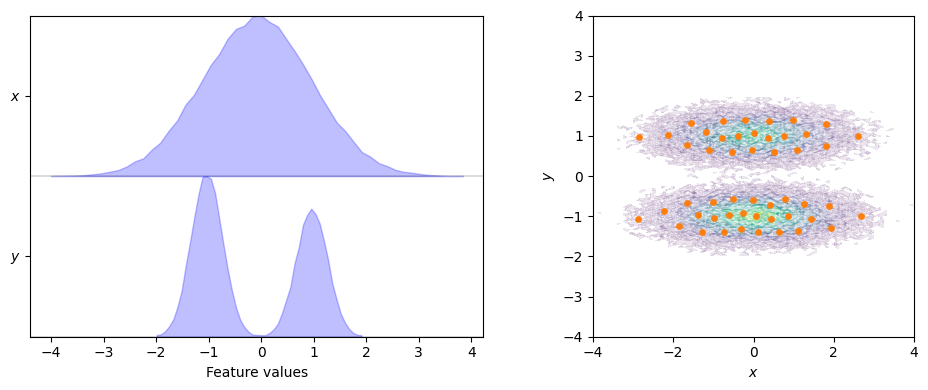

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$'], ax=axes[0])
pyemma.plots.plot_density(*data.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
fig.tight_layout()

The first step after obtaining the discretized dynamics is finding a suitable lag time.
The systematic approach is to estimate MSMs at various lag times and observe how the implied timescales (ITSs) of these models behave.
In particular, we are looking for lag time ranges in which the implied timescales are constant
(i.e., lag time independent as described in the manuscript in Section 2.1).
To this aim, PyEMMA provides the `its()` function which we use to track the first three (`nits=3`) implied timescales:

In [4]:
its = pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 3, 5, 7, 10], nits=3, errors='bayes')

/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


estimating BayesianMSM:   0%|                             | 0/6 [00:00<?, ?it/s]

We can pass the returned `its` object to the `pyemma.plots.plot_implied_timescales()` function:

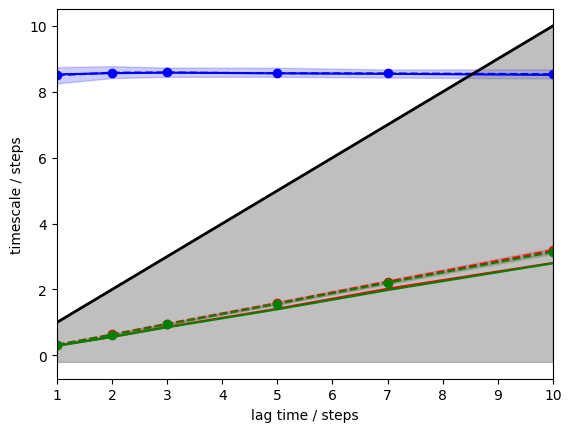

In [5]:
pyemma.plots.plot_implied_timescales(its, ylog=False);

The above plot tells us that there is one resolved process with an ITS of approximately $8.5$ steps (blue) which is largely invariant to the MSM lag time.
The other two ITSs (green, red) are smaller than the lag time (black line, grey-shaded area);
they correspond to processes which are faster than the lag time and, thus, are not resolved.
Since the implied timescales are, like the corresponding eigenvalues, sorted in decreasing order,
we know that all other remaining processes must be even faster.

As MSMs tend to underestimate the true ITSs, we are looking for a converged maximum in the ITS plot.
In our case, any lag time before the slow process (blue line) crosses the lag time threshold (black line) would work.
To maximize the kinetic resolution, we choose the lag time $1$ step.

To see whether our model satisfies Markovianity, we perform (and visualize) a Chapman-Kolmogorow (CK) test.
Since we aim at modeling the dynamics between metastable states rather than between microstates, this will be conducted in the space of metastable states.
The latter are identified automatically using PCCA++ (which is explained in [Notebook 05 📓](05-pcca-tpt.ipynb)).
We usually choose the number of metastable states according to the implied timescales plot by identifying a gap between the ITS.
For a single process, we can assume that there are two metastable states between which the process occurs.

estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

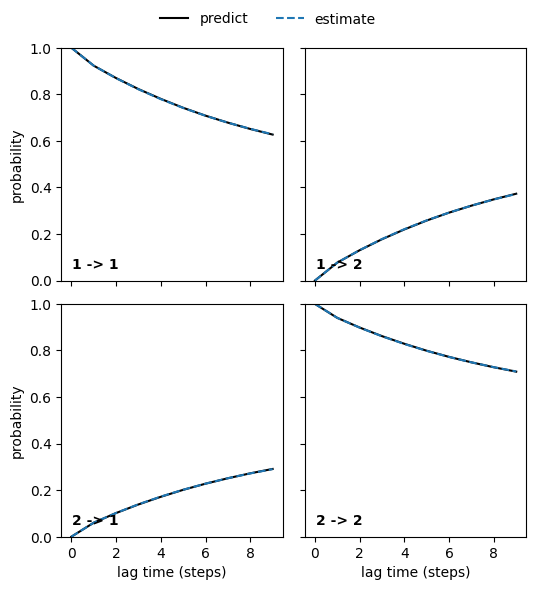

In [6]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=1)
pyemma.plots.plot_cktest(msm.cktest(2));

We can see a perfect agreement between models estimated at higher lag times and predictions of the model at lag time $1$ step.
Thus, we have estimated a valid MSM according to basic model validation.

Should a CK test fail, it means that the dynamics in the space of metastable states is not Markovian.
This can have multiple causes since it is the result of the combination of all steps in the pipeline.
In practice, one would attempt to find a better model by tuning hyper-parameters such as the number of metastable states, the MSM lag time or the number of cluster centers.
Back-tracking the error by following the pipeline in an upstream direction,
i.e., by starting with the number of metastable states, is usually advised. 

A failing CK test might further hint at poor sampling.
This case is explained in more detail in [Notebook 08 📓](08-common-problems.ipynb#poorly_sampled_dw).

## Case 2: low-dimensional molecular dynamics data (alanine dipeptide)
We fetch the alanine dipeptide data set, load the backbone torsions into memory and directly discretize the full space using $k$-means clustering.
In order to demonstrate how to adjust the MSM lag time,
we will first set the number of cluster centers to $200$ and justify this choice later.

In [7]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

cluster = pyemma.coordinates.cluster_kmeans(data, k=200, max_iter=50, stride=10)

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/3 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                      | 0/200 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

26-02-25 14:16:52 pyemma.coordinates.clustering.kmeans.KmeansClustering[8] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


From the discrete trajectories, implied timescales can be estimated:

In [8]:
its = pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


getting output of KmeansClustering:   0%|                 | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                             | 0/6 [00:00<?, ?it/s]

We visualize the marginal and joint distributions of both components as well as the cluster centers,
and show the ITS convergence to help selecting a suitable lag time:

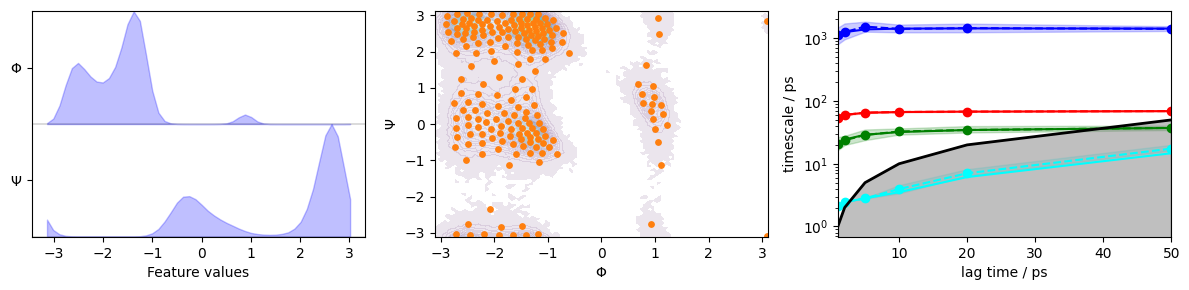

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*data_concatenated.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

We observe three resolved processes with flat ITS for a lag time of approximately $10$ ps.

Please note though that this ITS convergence analysis is based on the assumption that $200$ $k$-means centers are sufficient to discretize the dynamics.
In order to study the influence of the clustering on the ITS convergence,
we repeat the clustering and ITS convergence analysis for various number of cluster centers.
For the sake of simplicity, we will restrict ourselves to the $k$-means algorithm; alternative clustering methods are presented in [Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb).

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                       | 0/20 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

26-02-25 14:17:05 pyemma.coordinates.clustering.kmeans.KmeansClustering[12] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


getting output of KmeansClustering:   0%|                 | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                             | 0/6 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                       | 0/50 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

26-02-25 14:17:15 pyemma.coordinates.clustering.kmeans.KmeansClustering[16] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


getting output of KmeansClustering:   0%|                 | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                             | 0/6 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                      | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

26-02-25 14:17:29 pyemma.coordinates.clustering.kmeans.KmeansClustering[20] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


getting output of KmeansClustering:   0%|                 | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                             | 0/6 [00:00<?, ?it/s]

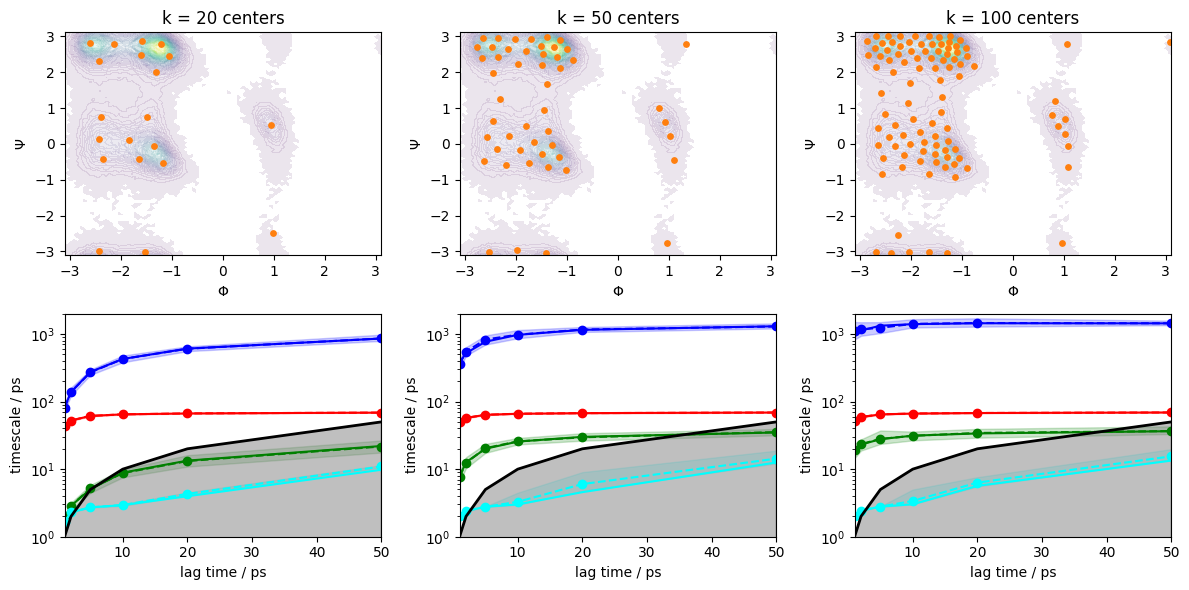

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, k in enumerate([20, 50, 100]):
    cluster = pyemma.coordinates.cluster_kmeans(data, k=k, max_iter=50, stride=10)
    pyemma.plots.plot_density(*data_concatenated.T, ax=axes[0, i], cbar=False, alpha=0.1)
    axes[0, i].scatter(*cluster.clustercenters.T, s=15, c='C1')
    axes[0, i].set_xlabel('$\Phi$')
    axes[0, i].set_ylabel('$\Psi$')
    axes[0, i].set_title('k = {} centers'.format(k))
    pyemma.plots.plot_implied_timescales(
        pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes'),
        ax=axes[1, i], units='ps')
    axes[1, i].set_ylim(1, 2000)
fig.tight_layout()

We can see from this analysis that the ITS curves indeed converge towards the $200$ centers case and we can continue with estimating/validating an MSM.

Before we continue with MSM estimation, let us discuss implied timescales convergence for large systems.
Given sufficient sampling, the task is often to find a discretization that captures the process of interest well enough to obtain implied timescales that converge within the trajectory length. 

As we see in the above example with $k=20$ cluster centers,
increasing the MSM lag time compensates for poor discretization to a certain extent.
In a more realistic system, however, trajectories have a finite length that limits the choice of our MSM lag time.
Furthermore, our clustering might be worse than the one presented above,
so convergence might not be reached at all.
Thus, we aim to converge the implied timescales at a low lag time by fine-tuning not only the number of cluster centers,
but also feature selection and dimension reduction measures.
This additionally ensures that our model has the maximum achievable temporal resolution.

Please note that choosing an appropriate MSM lag time variationally
(e.g., using VAMP scoring) is as far as we know not possible.

Further details on how to account for poor discretization can be found in our notebook about hidden Markov models [Notebook 07 📓](07-hidden-markov-state-models.ipynb).
An example on how implied timescales behave in the limit of poor sampling is shown in [Notebook 08 📓](08-common-problems.ipynb).

Now, let's continue with the alanine dipeptide system.
We estimate an MSM at lag time $10$ ps and, given that we have three slow processes, perform a CK test for four metastable states.

⚠️ In general, the number of metastable states is a modeler's choice and will be explained in more detail in [Notebook 04 ➜ 📓](04-msm-analysis.ipynb) and [Notebook 07 ➜ 📓](07-hidden-markov-state-models.ipynb).

estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

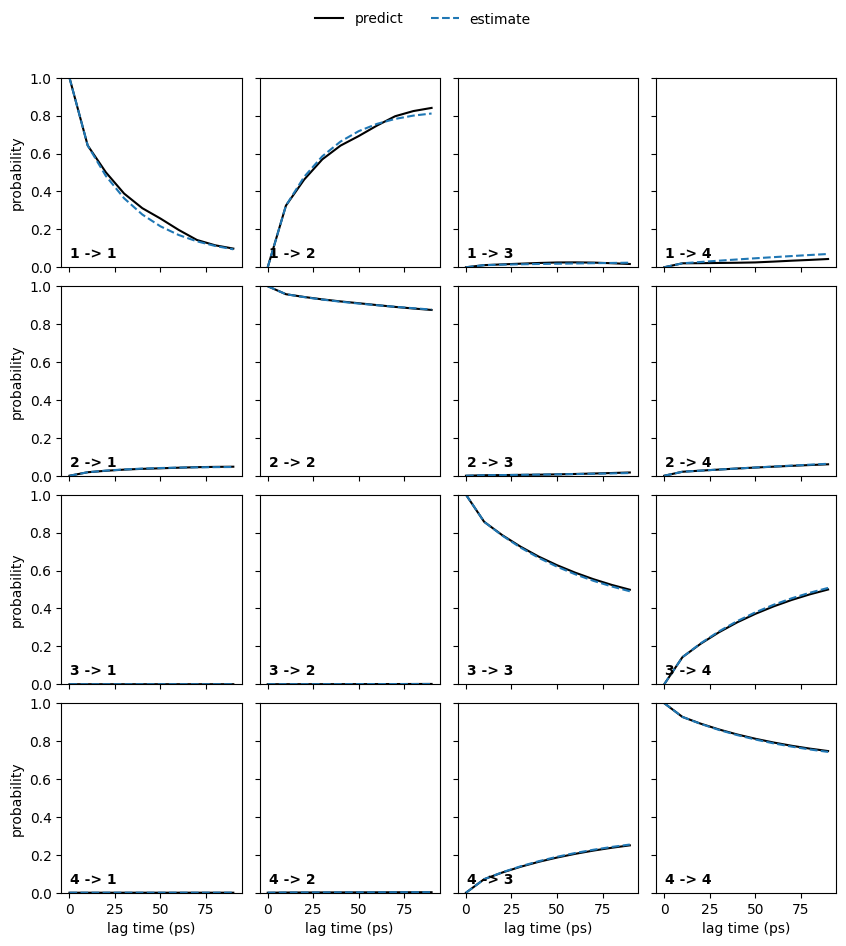

In [11]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')
pyemma.plots.plot_cktest(msm.cktest(4), units='ps');

The model prediction and re-estimation are in quite good agreement but we do see some small deviations in the first row.

To obtain error bars for the model prediction,
we estimate a Bayesian MSM under the same conditions as the regular MSM and repeat the CK test for the Bayesian model:

pyemma.msm.estimators.bayesian_msm.BayesianMSM[27]: Sampling MSMs:   0%| | 0/100

estimating BayesianMSM:   0%|                             | 0/9 [00:00<?, ?it/s]

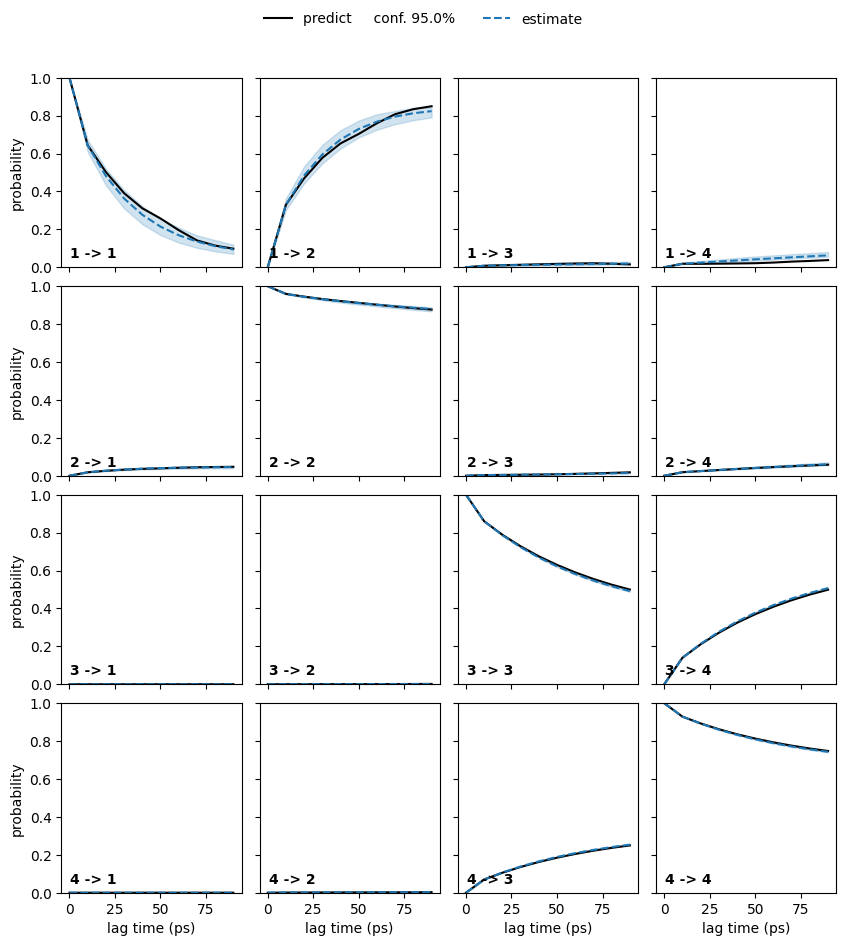

In [12]:
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps', conf=0.95)
pyemma.plots.plot_cktest(bayesian_msm.cktest(4), units='ps');

Bayesian MSMs are an extension of regular maximum likelihood (ML) MSMs that represent a sample of (reversible) transition matrices.
As presented here, they are usually used to compute confidence intervals.

A regular MSM estimates a single transition matrix which maximizes the likelihood of the data given the model.
Thus, all derived quantities are based on this ML estimation.
A Bayesian MSM, in comparison, starts with a ML-MSM and samples transition matrices using a Monte Carlo scheme.
Hence, target property posterior distributions can be estimated by computing these properties from each individual transition matrix in the sample. 

The initial ML-MSM used for the transition matrix sampling is contained in the `BayesianMSM` object with its properties accessible to the user.
Please note that different default estimation parameters might yield results that numerically differ from a directly estimated ML-MSM.

In the case of the low dimensional molecular dynamics data, we thus observe that the deviations are within a $95\%$ confidence interval.

### Persisting and restoring estimators

Because some estimations we have performed so far require more computational effort (e.g., TICA or kmeans with lots of centers),
it could be desirable to persist the resulting models in a file.
Luckily, PyEMMA provides a convenience method for this.
Just try it out:

In [13]:
cluster.save('nb3.pyemma', model_name='kmeans_k200')

/opt/Python-3.11.10/lib/python3.11/site-packages/pyemma/_base/serialization/pickle_extensions.py:58: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


Now we have stored the current state of the clustering estimator to disk.
A file can contain multiple models, this is why we have used the `model_name` argument to specify the name.
If omitted, the estimator will be saved under the name `default_model`.

Assume that we have restarted our Python session and do not want to re-compute everything.
We can now restore the previously saved estimator via

In [14]:
cluster_restored = pyemma.load('nb3.pyemma', model_name='kmeans_k200')

# check that nothing has changed
np.testing.assert_allclose(cluster_restored.clustercenters, cluster.clustercenters, atol=1e-15)

To check the contents of a file, you can utilize the list_models function of PyEMMA:

In [15]:
pyemma.list_models('nb3.pyemma')

{'kmeans_k200': {'created': np.float64(1740597476.3172176),
  'created_readable': 'Wed Feb 26 14:17:56 2025',
  'class_str': "KmeansClustering(clustercenters=array([[-1.26616,  0.089  ],\n       [-1.2863 ,  2.50878],\n       ...,\n       [-2.45728,  3.01811],\n       [-1.14114, -0.92106]], dtype=float32),\n         fixed_seed=959645622, init_strategy='kmeans++', keep_data=False,\n         max_iter=50, metric='euclidean', n_clusters=100, n_jobs=32,\n         oom_strategy='memmap', skip=0, stride=10, tolerance=1e-05)",
  'class_repr': "KmeansClustering(clustercenters=array([[-1.26616,  0.089  ],\n       [-1.2863 ,  2.50878],\n       ...,\n       [-2.45728,  3.01811],\n       [-1.14114, -0.92106]], dtype=float32),\n         fixed_seed=959645622, init_strategy='kmeans++', keep_data=False,\n         max_iter=50, metric='euclidean', n_clusters=100, n_jobs=32,\n         oom_strategy='memmap', skip=0, stride=10, tolerance=1e-05)",
  'saved_streaming_chain': np.False_,
  'pyemma_version': '2.5.

In [16]:
# we now remove this files again
import os
os.unlink('nb3.pyemma')

As you see, all important attributes of an estimator will be stored.
PyEMMA provides future compatibility of stored estimators,
which means that you can always load your files in a new version, but are then restricted to not using older ones.

#### Exercise 1

Load the heavy atom distances into memory, perform PCA and TICA (`lag=3`) with `dim=2`,
then discretize with $100$ $k$-means centers and a stride of $10$.

In [ ]:
feat =  #FIXME
feat. #FIXME
data =  #FIXME

pca = pyemma.coordinates.pca(data, dim=2)
tica = #FIXME

pca_concatenated = np.concatenate(pca.get_output())
tica_concatenated = #FIXME

cls_pca = pyemma.coordinates.cluster_kmeans(pca, k=100, max_iter=50, stride=10)
cls_tica = #FIXME

its_pca = pyemma.msm.its(
    cls_pca.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')
its_tica = #FIXME

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Heavy())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)

pca = pyemma.coordinates.pca(data, dim=2)
tica = pyemma.coordinates.tica(data, lag=3, dim=2)

pca_concatenated = np.concatenate(pca.get_output())
tica_concatenated = np.concatenate(tica.get_output())

cls_pca = pyemma.coordinates.cluster_kmeans(pca, k=100, max_iter=50, stride=10)
cls_tica = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50, stride=10)

its_pca = pyemma.msm.its(
    cls_pca.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')
its_tica = pyemma.msm.its(
    cls_tica.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

Let's visualize the ITS convergence for both projections:

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
pyemma.plots.plot_feature_histograms(pca_concatenated, ax=axes[0, 0])
pyemma.plots.plot_feature_histograms(tica_concatenated, ax=axes[1, 0])
axes[0, 0].set_title('PCA')
axes[1, 0].set_title('TICA')
pyemma.plots.plot_density(*pca_concatenated.T, ax=axes[0, 1], cbar=False, alpha=0.1)
axes[0, 1].scatter(*cls_pca.clustercenters.T, s=15, c='C1')
axes[0, 1].set_xlabel('PC 1')
axes[0, 1].set_ylabel('PC 2')
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1, 1], cbar=False, alpha=0.1)
axes[1, 1].scatter(*cls_tica.clustercenters.T, s=15, c='C1')
axes[1, 1].set_xlabel('IC 1')
axes[1, 1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its_pca, ax=axes[0, 2], units='ps')
pyemma.plots.plot_implied_timescales(its_tica, ax=axes[1, 2], units='ps')
axes[0, 2].set_ylim(1, 2000)
axes[1, 2].set_ylim(1, 2000)
fig.tight_layout()

Despite the fact that PCA yields a projection with some defined basins,
the ITS plot shows that only one "slow" process is resolved which is more than one order of magnitude too fast.

TICA does find three slow processes which agree (in terms of the implied timescales) with the backbone torsions example above.

We conclude that this PCA projection is not suitable to resolve the slow dynamics of alanine dipeptide and we will continue to estimate/validate the TICA-based projection.

#### Exercise 2

Estimate a Bayesian MSM at lag time $10$ ps and perform/show a CK test for four metastable states.

In [ ]:
bayesian_msm = pyemma.msm.bayesian_markov_model(cls_tica.dtrajs, lag=10, dt_traj='1 ps')
pyemma.plots. #FIXME

###### Solution

In [ ]:
bayesian_msm = pyemma.msm.bayesian_markov_model(cls_tica.dtrajs, lag=10, dt_traj='1 ps')
pyemma.plots.plot_cktest(bayesian_msm.cktest(4), units='ps');

We again see a good agreement between model prediction and re-estimation.

## Wrapping up
In this notebook, we have learned how to estimate a regular or Bayesian MSM from discretized molecular simulation data with `pyemma` and how to perform basic model validation.
In detail, we have selected a suitable lag time by using
- `pyemma.msm.its()` to obtain an implied timescale object and
- `pyemma.plots.plot_implied_timescales()` to visualize the convergence of the implied timescales.

We then have used
- `pyemma.msm.estimate_markov_model()` to estimate a regular MSM,
- `pyemma.msm.bayesian_markov_model()` to estimate a Bayesian MSM,
- the `timescales()` method of an estimated MSM object to access its implied timescales,
- the `cktest()` method of an estimated MSM object to perform a Chapman-Kolmogorow test, and
- `pyemma.plots.plot_cktest()` to visualize the latter.

## References

<a id="cite-msm-jhp"/><sup><a href=#ref-1>[^]</a></sup>Prinz, Jan-Hendrik and Wu, Hao and Sarich, Marco and Keller, Bettina and Senne, Martin and Held, Martin and Chodera, John D. and Schütte, Christof and Noé, Frank. 2011. _Markov models of molecular kinetics: Generation and validation_. [URL](http://scitation.aip.org/content/aip/journal/jcp/134/17/10.1063/1.3565032)

<a id="cite-msm-book"/><sup><a href=#ref-2>[^]</a></sup>Gregory R. Bowman and Vijay S. Pande and Frank Noé. 2014. _An Introduction to Markov State Models and Their Application to Long Timescale Molecular Simulation_. [URL](https://doi.org/10.1007%2F978-94-007-7606-7)

<a id="cite-msm-brooke"/><sup><a href=#ref-3>[^]</a></sup>Brooke E. Husic and Vijay S. Pande. 2018. _Markov State Models: From an Art to a Science_.

